# Ramsey

In [1]:
# Import section
using Interpolations
using Plots
using LaTeXStrings
using Optim
using FastGaussQuadrature

In [2]:
## Model Parameters 

# Production side f(k, a) = exp(a)kᵅ
α = 0.34;
δ = 1;

# Preference and Utility
β = 0.96;
γ = 2;

# Stochastic Process a' = ρa + ση
σ = 1;
ρ = 0.99;

Recall:

$$\mathbb{E}[f(\varepsilon_{t+1}) | \varepsilon_t] = \approx \sum_{i = 1}^n \frac{\omega_i}{\sqrt{\pi}}f(\sqrt{2}\sigma y_i + \rho \varepsilon_t) = Ef(\varepsilon_t)$$

In [3]:
# Quadrature Nodes and weights, we use 5 Nodes
y, ω = gausshermite(5)

([-2.0201828704560856, -0.9585724646138198, -4.440892098500626e-16, 0.9585724646138198, 2.0201828704560856], [0.019953242059045872, 0.3936193231522408, 0.9453087204829428, 0.3936193231522408, 0.019953242059045872])

In [4]:
# State space parameters
grid = 100
agrid = 3
A = LinRange(0, 0.5, agrid);
K = LinRange(0.01, 1, grid);
one = zeros(grid, agrid);

# Utility
u(c) = (c^(1 - γ) - 1)/(1 - γ)

# Production function
f(k, a) = broadcast(exp, a).*k.^α

f (generic function with 1 method)

In [5]:
# Instantiate Value function on the multidimensional domain
V = cubic_spline_interpolation((K, A), one, extrapolation_bc = Line());

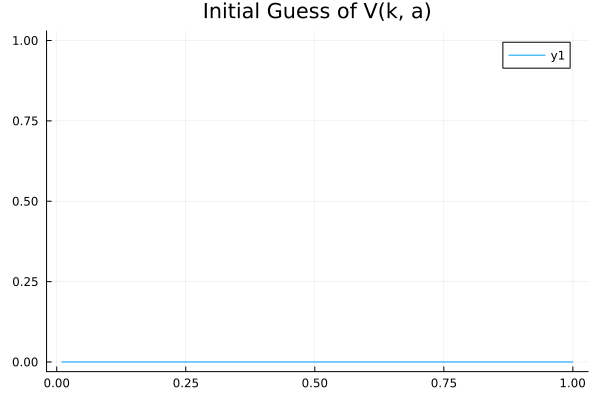

In [6]:
plot(K, V(K, 1), title="Initial Guess of V(k, a)")

In [7]:
# When we call on multiple arrays
V(K, A)[1:5,:]

5×3 Matrix{Float64}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

# Bellman operator

$$T(V)(k, a) = \max_{c \in [0, f(k, a) + (1 - \delta)k]}\left\{u(c) + \beta \mathbb{E}[V(f(k, a) + (1 - \delta)k - c, a') | k, a] \right\}$$

So the problem here get's harder because we have to compute the expectation, but nothing our heroes cannot do!

$$\mathbb{E}[V(f(k, a) + (1 - \delta)k - c, a') | k, a] = \int_{-\infty}^\infty V(f(k, a) + (1 - \delta)k - c, a')g(a' | a)da' = EV(k, a, c)$$

Therefore we have to program an expectation function

In [8]:
function EV(v, k, a, c)
    ap = sqrt(2).*y .+ ρ.*a
    integrand = (ω./sqrt(pi)).* v(f(k, a) .+ (1 - δ).*k .- c, ap)
    return sum(integrand)
end

EV (generic function with 1 method)

In [9]:
# Bellman operator
function T(v)

    # Instantiate Tv and a
    Tv = zeros(grid, agrid)
    c = zeros(grid, agrid)

    # for each point of capital
    for i in 1:grid
        # for each point in the TFP shock
        for j in 1:agrid

            # Right hand side
            rhs(c) = - (u(c) + β*EV(v, K[i], A[j], c))
            result = optimize(rhs, 0, f(K[i], A[j]) + (1 - δ)*K[i])

            # Assign values
            Tv[i, j] = -Optim.minimum(result)
            c[i, j] = Optim.minimizer(result)[1]
        end
    end
    
    return Tv, c
end

T (generic function with 1 method)

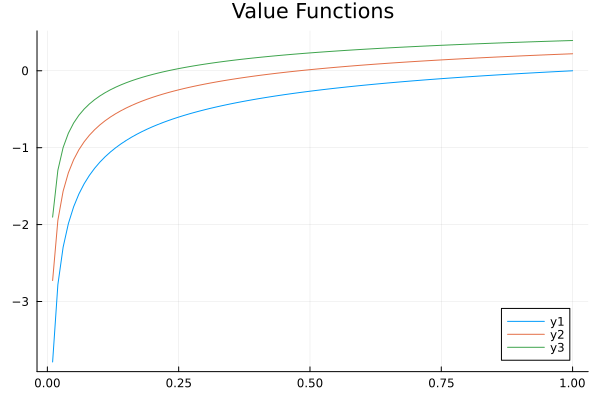

In [10]:
tv, c = T(V);
p = plot(K, tv[:, 1], title="Value Functions")
for a in 2:agrid
    plot!(K, tv[:, a])
end
display(p)

In [11]:
# Set tolerance and error 
ε = 1e-6;
err = Inf;
it = 0;

In [12]:
# Actual loop
plots = []
while err > ε

    # Apply the operator and get the new value function
    v_new, c = T(V)
    push!(plots, v_new)

    # Compute the error 
    err = maximum(broadcast(abs, (v_new - V(K, A))))
    print(err,"\n")

    # Re-interpolate the value function
    V = cubic_spline_interpolation((K, A), v_new, extrapolation_bc = Line());
    it = it + 1
end
print("$err and it: $it")

3.786301039211592
3.250934071313545
2.586816472932081
2.328549910155605


2.2022827304985437
2.1205801902360815
2.049955349725014
1.9800215172539062


1.90916752901067
1.8380983228174976
1.7676832380984457
1.6987265865571182


1.6317690161087377
1.567058564436607
1.5046459294370749
1.4445842448761397


1.386865271562371
1.3314289259559686
1.2781904908171065
1.2270720662499208


1.1779936666002868
1.130876087385154
1.085642094053071
1.0422169266637624


1.0005285084073492
0.9605074998012171
0.9220872676067771
0.8852038121765702


0.8497956806456273
0.8158038638682896
0.7831717140759054
0.7518448476495934


0.7217710546832166
0.6929002129329476
0.6651842046002372
0.6385768365269655


0.6130337630932345
0.5885124126049632
0.5649719161202214
0.5423730394886022


0.5206781179189193
0.49985099319624027
0.47985695347490065
0.46066267533193894


0.44223616832347545
0.42454672159889384
0.40756485272763854
0.3912622586207348


0.3756117682717601
0.3605872975339821
0.3461638056335161
0.33231725341671847


0.319024563277452
0.30626358074339777
0.2940130375179706
0.2822525160162428


0.27096241537946497
0.26012391877103624
0.24971896201107313
0.23973020353649588


0.23014099538839616
0.22093535557112176
0.21209794135926785
0.20361402369790937


0.19546946275291788
0.18765068424483644
0.18014465686304248
0.1729388705944288


0.16602131576953383
0.15938046313718246
0.15300524461887477
0.1468850348305324


0.14100963343562967
0.1353692481001616
0.12995447817596073
0.12475629904964336


0.11976604708776506
0.11497540520289107
0.1103763889950855
0.10596133344172642


0.1017228801017751
0.09765396490374201
0.09374780631738844
0.08999789405957159


0.08639797829319207
0.08294205915424868
0.0796243767902638
0.0764394017169181


0.0733818256483687
0.0704465526233804
0.06762869052576548
0.06492354291477653


0.062326601197312925
0.05983353713946826
0.057440195651857096
0.055142587832982315


0.05293688431164867
0.050819408934472676
0.04878663258558902
0.04683516727323678


0.044961760593920985
0.04316329016421605
0.04143675856018092
0.0397792882245156


0.03818811669187028
0.036660592024972516
0.03519416834308231
0.0337864016048286


0.03243494554620696
0.031137547733763427
0.029892045837598857
0.02869636398772002


0.027548509433763968
0.02644656904923437
0.025388706286626928
0.02437315802778528


0.0233982317101038
0.02246230245530967
0.021563810355694102
0.02070125794630684


0.019873207620456412
0.01907827931417927
0.018315148142292514
0.017582542224552355


0.016879240531096684
0.01620407089914977
0.01555590806640339
0.014933671743833088


0.014336324873333695
0.013762871890705242
0.013212357011866516
0.012683862735123341


0.012176508225763882
0.011689447879831505
0.011221869964359144
0.010772995169020305


0.010342075364320635
0.009928392347539727
0.009531256653588116
0.009150006392374621


0.008784006145091894
0.008432645901692126
0.008095340066525125
0.0077715264541424744


0.007460665408302702
0.007162238800944465
0.006875749228093753
0.006600719268732291


0.0063366905020529884
0.006083222880008066
0.005839893965664089
0.005606298205933058


0.005382046268138652
0.0051667644143691405
0.004960093842640845
0.004761690092479398


0.004571222496537075
0.004388373592576045
0.0042128386449604704
0.004044325101077106


0.0038825521023326814
0.003727250014691208
0.0035781600126085777
0.003435033611452809


0.0032976322682287673
0.0031657269789775455
0.003039097901719856
0.002917533986405374


0.002800832627436023
0.002688799333235181
0.0025812473456596763
0.002477997457823733


0.0023788775662438866
0.002283722450329151
0.0021923735531714783
0.002104678619971878


0.0020204914759176518
0.001939671817652311
0.001862084946850473
0.0017876015447129134


0.001716097473888567
0.0016474535884896113
0.0015815554443747715
0.0015182932264892202


0.0014575615029741584
0.00139925902921334
0.0013432886767077434
0.0012895571338447098


0.0012379748475837005
0.0011884558554697833
0.0011409176177394897
0.001095280913489205


0.0010514696751400265
0.0010094108837535032
0.0009690344517707672
0.0009302730752622779


0.000893062161992475
0.0008573396642077569
0.0008230460825160435
0.0007901242447161394


0.0007585192773333915
0.0007281785068755653
0.0006990513706242041
0.0006710893025569931


0.0006442457220146025
0.0006184758972409554
0.0005937368798072384
0.000569987397540217


0.0005471878944121045
0.0005253003873946227
0.0005042883686883215
0.00048411682855231675


0.00046475216090158256
0.0004461620667584043
0.00042831558650391344
0.00041118297181697017


0.0003947356579345751
0.00037894623552858775
0.0003637883781379969
0.00034923684441423575


0.0003352673686123353
0.0003218566686840063
0.0003089823969162353
0.0002966231026491073


0.00028475818126594277
0.00027336786888554343
0.00026243314364648995
0.0002519358095085522


0.0002418583853511791
0.00023218406227698551
0.00022289669472286278
0.00021398082395762685


0.00020542158339509342
0.00019720472950268686
0.00018931653146125882
0.00018174388654301765


0.00017447412872684254
0.00016749516312586366
0.00016079535321011917
0.00015436353281472748


0.00014818899849444733
0.00014226143954942927
0.000136570988310325
0.00013110814610683974


0.0001258638224612696
0.00012082926718193221
0.00011599609471346639
0.00011135623969948938


0.00010690199798091271
0.00010262591993637216
9.852089456785507e-5
9.458005788332002e-5


9.079684383550557e-5
8.716497033844917e-5
8.367837552469837e-5
8.033125379824924e-5


7.711799142384734e-5
7.403326729615856e-5
7.107193495414776e-5
6.822906466652512e-5


6.549989915072274e-5
6.287990480302597e-5
6.036470048798037e-5
5.7950115703420124e-5


5.56321171103491e-5
5.3406830829771934e-5
5.1270555395888096e-5
4.9219731877769846e-5


4.7250951070054725e-5
4.536091016404953e-5
4.354646915771809e-5
4.180461301928062e-5


4.0132435671580424e-5
3.8527137029120695e-5
3.6986044378295446e-5
3.550661028839386e-5


3.408635340917954e-5
3.2722905288551374e-5
3.141398994443989e-5
3.0157428184907076e-5


2.89511131725817e-5
2.7793067772563518e-5
2.668135130790006e-5
2.5614095811477e-5


2.4589534703522986e-5
2.3605948776150854e-5
2.2661723733108374e-5
2.1755262736178338e-5


2.0885049273999812e-5
2.0049642287744973e-5
1.9247655998810842e-5
1.8477761024371375e-5


1.7738651116872006e-5
1.7029086464503962e-5
1.63479287635937e-5
1.5694018344447613e-5


1.5066267067709305e-5
1.4463618200011297e-5
1.3885068405272705e-5
1.332965496203542e-5


1.2796467267151002e-5
1.2284604437695634e-5
1.179322120492543e-5
1.1321500664962514e-5


1.086864989474634e-5
1.0433902843942633e-5
1.0016544905511182e-5
9.615894043690787e-6


9.231247688035182e-6
8.861985357100366e-6
8.507500993459871e-6
8.167210310716655e-6


7.84052602398333e-6
7.526911247168755e-6
7.225838281499364e-6
6.936799010759387e-6


6.659331674541136e-6
6.392963243229133e-6
6.1372369799528315e-6
5.891755975540036e-6


5.656080759308679e-6
5.42984810181224e-6
5.212633709561487e-6
5.004135303465773e-6


4.803962141863849e-6
4.611808435583953e-6
4.427332868317535e-6
4.250246085746312e-6


4.080235520120823e-6
3.917025210853353e-6
3.7603406113362325e-6
3.609925940395442e-6


3.4655276621720077e-6
3.326901648392777e-6
3.1938307643031294e-6
3.06607535094372e-6


2.94344273754632e-6
2.8257072983706166e-6
2.7126947585998096e-6
2.604163661601433e-6


2.500002167948878e-6
2.4000087677222837e-6
2.304017478138576e-6
2.2118568594464705e-6


2.1233697964362364e-6
2.0384365555514705e-6
1.9568996947327832e-6
1.8786292059758125e-6


1.8034759960983138e-6
1.7313370079818924e-6
1.6620913498854861e-6
1.5956107333181535e-6


1.5317834254346963e-6
1.4705145048310442e-6
1.4116927218310593e-6
1.3552273259165304e-6


1.3010030386340077e-6
1.2489674503513015e-6
1.1990072152912035e-6
1.1510496591427e-6


1.105008308854849e-6
1.0608120248889463e-6
1.0183678256225903e-6
9.776316716170186e-7
9.776316716170186e-7 and it: 364

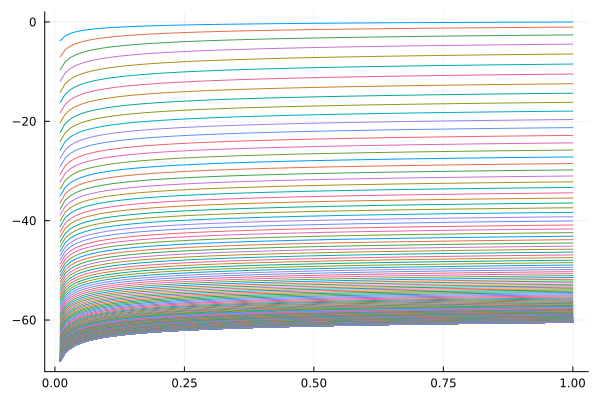

In [13]:
p = plot(K, plots[1][:,1], label="")
for i in 2:length(plots)
    plot!(K,plots[i][:,1], label = "")
end
display(p)

# Plots of the functions

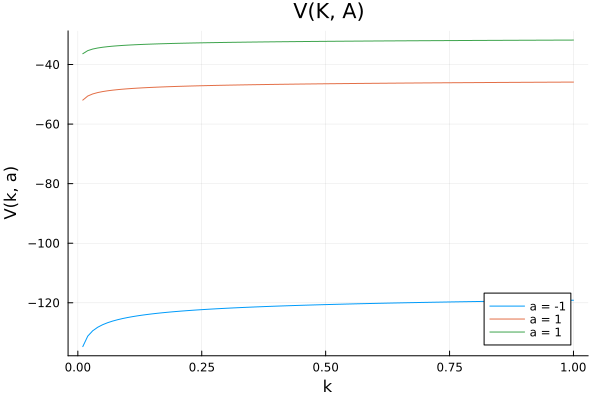

In [14]:
p1 = plot(K, V(K, -1), title="V(K, A)", xlabel = "k", ylabel="V(k, a)", label="a = -1")
for i in 2:agrid
    plot!(K, V(K, A[i]), label = "a = 1")
end 
display(p1)

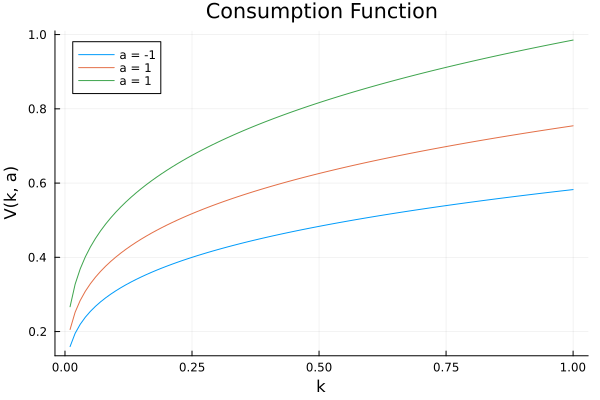

In [15]:
p2 = plot(K, c[:, 1], title="Consumption Function", xlabel = "k", ylabel="V(k, a)", label="a = -1")
for i in 2:agrid
    plot!(K, c[:, i], label = "a = 1")
end 
display(p2)

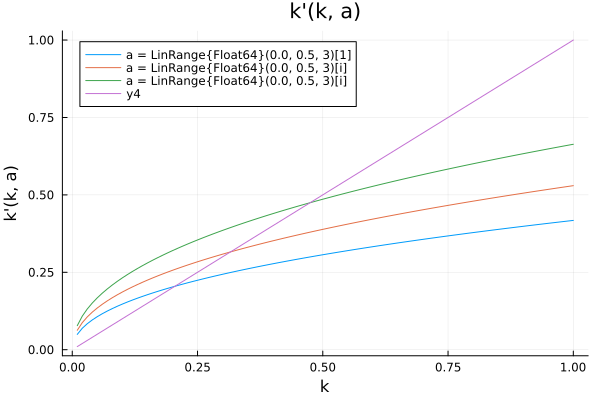

In [16]:
p3 = plot(K, f(K, A[1]) .+ (1 - δ).*K .- c[:, 1], title="k'(k, a)", xlabel = "k", ylabel="k'(k, a)", label="a = $A[1]")
for i in 2:agrid
    plot!(K, f(K, A[i]) .+ (1 - δ).*K .- c[:, i], label = "a = $A[i]")
end 
plot!(K, K)
display(p3)